# Big Data Platform
## Assignment 3: ServerLess

**The goal of this assignment is to:**
- Understand and practice the details of Serverless

**Instructions:**
- Students will form teams of two people each, and submit a single homework for each team.
- The same score for the homework will be given to each member of your team.
- Your solution is in the form of a Jupyter notebook file (with extension ipynb).
- Images/Graphs/Tables should be submitted inside the notebook.
- The notebook should be runnable and properly documented. 
- Please answer all the questions and include all your code.
- You are expected to submit a clear and pythonic code.
- You can change functions signatures/definitions.

**Submission:**
- Submission of the homework will be done via Moodle by uploading (not Zip):
    - Jupyter Notebook
    - 2 Log files
    - Additional local scripts
- The homework needs to be entirely in English.
- The deadline for submission is on Moodle.
- Late submission won't be allowed.

  
- In case of identical code submissions - both groups will get a Zero. 
- Some groups might be selected randomly to present their code.

**Requirements:**  
- Python 3.6 should be used.  
- You should implement the algorithms by yourself using only basic Python libraries (such as numpy,pandas,etc.)

<br><br><br><br>

**Grading:**
- Q0 - 10 points - Setup
- Q1 - 40 points - Serverless MapReduceEngine
- Q2 - 20 points - MapReduce job to calculate inverted index
- Q3 - 30 points - Shuffle

`Total: 100`

<br><br>

# Question 0
## Setup

1. Navigate to IBM Cloud and open a trial account. No need to provide a credit card
2. Choose IBM Cloud Object Storage service from the catalog
3. Create a new bucket in IBM Cloud Object Storage
4. Create credentials for the bucket with HMAC (access key and secret key)
5. Choose IBM Cloud Functions service from the catalog and create a service


#### Lithops setup
1. By using “git” tool, install master branch of the Lithops project from
https://github.com/lithops-cloud/lithops
2. Follow Lithops documentation and configure Lithops against IBM Cloud Functions and IBM Cloud Object Storage
3. Configure Lithops log level to be in DEBUG mode
4. Run Hello World example by using Futures API and verify all is working properly.


#### IBM Cloud Object Storage setup
1. Upload all the input CSV files that you used in homework 2 into the bucket you created in IBM Cloud Object Storage


<br><br><br>

In [ ]:
# !pip install lithops

In [ ]:
import sqlite3
import os
import lithops
import shutil
import names
import random

import pandas as pd

! lithops test

In [ ]:
# define folder path in which the data will be saved
folder_path = './outputs'
if os.path.isdir('./outputs'):
    shutil.rmtree('./outputs')
os.mkdir('./outputs')

In [ ]:
firstname = ['John', 'Dana', 'Scott', 'Marc', 'Steven', 'Michael', 'Albert', 'Johanna']
city = ['NewYork', 'Haifa', 'Munchen', 'London', 'PaloAlto',  'TelAviv', 'Kiel', 'Hamburg']

# using 'names' library we could easily generate random second names
secondname = []
for i in range(len(firstname)):
    random_name = names.get_first_name()
    secondname.append(random_name)

# let's create the 20 csvs
for i in range(1,21):
    firstname_col = random.choices(firstname, k=10)
    secondname_col = random.choices(secondname, k=10)
    city_col = random.choices(city, k=10)
    df = pd.DataFrame(list(zip(firstname_col, secondname_col, city_col)),
                columns=['firstname', 'secondname', 'city'])
    df.to_csv(f'{folder_path}/myCSV{i}.csv', index=False)

In [ ]:
# check if the folder exist, if so then remove it and create a new one
if os.path.exists(f'{folder_path}/mapreducetemp'):
    shutil.rmtree(f'{folder_path}/mapreducetemp')
os.mkdir(f'{folder_path}/mapreducetemp')

if os.path.exists(f'{folder_path}/mapreducefinal'):
    shutil.rmtree(f'{folder_path}/mapreducefinal')
os.mkdir(f'{folder_path}/mapreducefinal')

In [ ]:
connection = sqlite3.connect(f'{folder_path}/hw3.db')
cursor = connection.cursor()

cursor.execute('''CREATE TABLE IF NOT EXISTS temp_results(
                    key text,
                    value text)''')

# Question 1
## Serverless MapReduceEngine

Modify MapReduceEngine from homework 2 into the MapReduceServerlessEngine where map and reduce tasks executed as a serverless actions, instead of local threads. In particular:
1. Deploy all map tasks as a serverless actions by using Lithops against IBM Cloud Functions.
2. Collect results from all map tasks and store them in the same SQLite as you used in MapReduceEngine and use the same code for the sort and shuffle phase.
3. Deploy reduce tasks by using Lithops against IBM Cloud Functions. Instead of persisting results from reduce tasks, return results back to the MapReduceServerlessEngine and proceed with the same workflow as in MapReduceEngine
4. Return results of reduce tasks to the user

**Please attach:**  
Text file with all log messages Lithops printed to console during the execution. Make
sure log level is set to DEBUG mode.

#### Code:

In [ ]:
class MapReduceServerlessEngine():
    
    def execute(self, input_data, map_function, reduce_function):
        
        with lithops.ServerlessExecutor(log_level='DEBUG') as fexec:

            for idx, key in enumerate(input_data):

                key = f"{folder_path}/{key}"
                f = fexec.call_async(map_function, (key, idx))
                f.result()

            for file in os.listdir(f'{folder_path}/mapreducetemp'):

                df = pd.read_csv(f'{folder_path}/mapreducetemp/{file}')
                df.to_sql('temp_results',connection, if_exists='append',index=False)
            
            cursor.execute('''SELECT key, GROUP_CONCAT(value) FROM temp_results GROUP BY key ORDER BY key''')
            key_value_list = cursor.fetchall()

            for idx, value in enumerate(key_value_list):
                f = fexec.call_async(reduce_function, (value[0], value[1], idx))
                f.result()
        

In [ ]:
def inverted_map(document_path: str, idx: int):
    
    """
    This function reads the CSV document from the local disc 
    and return a list that contains entries of the form (key_value, document name)
    """
    # read the csv and create an empty list
    document_name = document_path.split('/')[-1]
    data = pd.read_csv(document_path)

    inverted_list = []
    
    # convert each row in the csv to a dictionary and add it to the list
    for i in range(len(data)):
        row_dict = dict(data.iloc[i, :]) # {firstname: John, secondname: Bon, city: TelAviv}
        for key, value in row_dict.items():
            inverted_list.append((f'{key}_{value}',document_name)) # (firstname_John, secondname_Bon, city_TelAviv)
    
    df = pd.DataFrame(inverted_list, columns=['key', 'value'])
    df.to_csv(f'{folder_path}/mapreducetemp/part-tmp-{idx+1}.csv', index=False)
    

In [ ]:
def inverted_reduce(value, documents, idx):
    """
    The field “documents” contains a list of all CSV documents per given value.
    This list might have duplicates.
    The function will return new list without duplicates.
    """
    
    # convert the long string of csvs to a list
    documents = documents.split(',') 
    results = [value]+list(dict.fromkeys(documents))
    df = pd.DataFrame(results[1:], columns=[results[0]])
    df.to_csv(f'{folder_path}/mapreducefinal/part-{idx+1}-final.csv', index=False)


# Task 2
## Submit MapReduce job to calculate inverted index
1. Use input_data: `cos://bucket/<path to CSV data>`
2. Submit MapReduce job with reduce and map functions as you used in homework 2, as follows

    `mapreduce = MapReduceServerlessEngine()`  
    `results = mapreduce.execute(input_data, inverted_map, inverted_index)`   
    `print(results)`

**Please attach:**  
Text file with all log messages Lithops printed to console during the execution. Make
sure log level is set to DEBUG mode.

#### Code:

In [ ]:
input_data = [csv for csv in os.listdir(folder_path) if 'csv' in csv]
mapreduce = MapReduceServerlessEngine()
mapreduce.execute(input_data, inverted_map, inverted_reduce)

In [ ]:
# if the folder exists, delete it recursively
if os.path.exists(f'{folder_path}/mapreducetemp'):
    shutil.rmtree(f'{folder_path}/mapreducetemp')

# try to close the connection
try:
    cursor.close()
    connection.close()
# if the exception is 'ProgrammingError' then the connection is already close
# print it
except sqlite3.ProgrammingError:
    print('Connection is already closed!')

# if the database exists - remove it
if os.path.exists(f'{folder_path}/hw2.db'):
    os.remove(f'{folder_path}/hw2.db')

# Question 3
## Shuffle

MapReduceServerlessEngine deploys both map and reduce tasks as serverless invocations.   
However, once map stage completed, the result are transferred from the map tasks to the SQLite database located on the client machine (laptop in your case), then performed local shuffle and then invoked reduce tasks passing them relevant parameters.

(To support your answers, feel free to use examples, Images, etc.)
<br><br>

**1. Explain why this approach is not efficient and what are cons and pros of such architecture in general. In broader scope you may assume that MapReduceServerlessEngine executed in some powerful machine and not just laptop.**

This approach has it's Strengths and weeknesses like any other matter, we will name some of the cons and prons for ServerlessEngine architecture we see as most important.
<br><ins>cons:</ins>
1. most of the implementations still require at least one long-running server in a job execution
2. Some implementations of simple serverless MapReduce that cannot express complex data processing jobs.
3. some implementations are not open-source, not maintained or have an extremely complicated setup.

<br><ins>pros:</ins>
1. The Cloud provider dynamically allocates resources to the function invocations and fine-grained billing is introduced depending on the execution time and allocated memory, resulting in pay-as-you-go solution for the user.
2. This method leverage the high elasticity of serverless computing to efficiently support jobs whose resource requirements vary significantly during their execution.
3. Serverless computing is simple and powerful way to run embarrassingly parallel computations or harness proprietary services.

<br><br>
**2. Suggest how can you improve shuffle so intermediate data will not be downloaded to the client at all and shuffle performed in the cloud as well. Explain pros and cons of the approaches you suggest.**


We will present our thoughts regarding shuffling data using cloud services rather than shuffling data using a server, and include our conclusion.

Shuffling data on a severless engine costs very low when using slow storage systems (as low as 0.005$ per 1000 requests), but when sorting great amount of data, it will sum up to very expensive costs. Therefore, using server less services such as s3 for example will be very expensive Considering the running time.

Using shuffling on a severless engine with fast storage systems like Memcached or Redis, will be much more efficient and overcome the performance of the slow storage, but these systems are typically much more expensive than large-scale blob storage systems.


Our conclusion, Given the cost-performance trade-off between slow (S3) and fast ( Redis) storage, we recommend combining these two types of storage systems, so we can achieve a cost-performance sweet spot in a severless deployment that is comparable, and sometimes superior to cluster-based deployments.

<br><br>
**3. Can you make serverless shuffle?**


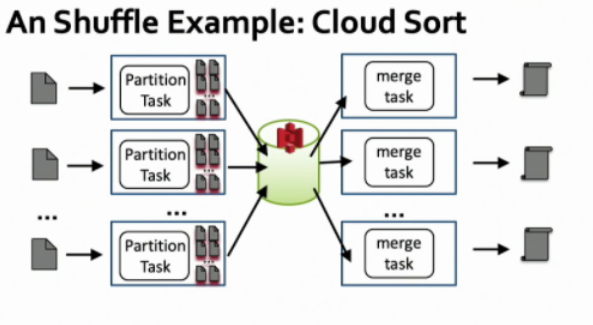

Yes, but you will need to persist the intermediary data in some type of persistent storage or in-memory/on-disk file system of the cloud provider, so the more you access the CPU Time/Memory, the higher the cost. The above image depicts this with the green cylinder representing the cloud storage system of the serverless provider. 

<br><br><br><br>
Good Luck :) 